# Reproducing EnKF parameter estimation results from Schneider et al. 2017

**Notation: Follow Yvonne's thesis**
- $X, Y$: Lorenz variables
- $x$: Model state
- $y$: observations
- $R$: Observation error covariance matrix 

In [4]:
%load_ext autoreload
%autoreload 2

In [114]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm_notebook as tqdm
from L96 import *
from copy import copy, deepcopy

In [69]:
# Create initial conditions
l96 = L96OneLevel()
l96.iterate(10000)
init = l96.X.copy()

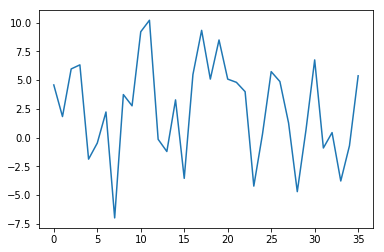

In [70]:
plt.plot(l96.X)

## Basic state estimation with the Kalman filter and the one level model

In [203]:
class EnKF():
    def __init__(self, l96, nens, obs_noise, nsteps):
        self.l96 = l96
        self.nens = nens
        self.obs_noise = obs_noise
        self.R = np.diag(np.ones(36) * obs_noise)   # No localization
        self.nsteps = nsteps
        
    def initialize(self, ic, ic_noise):
        # Initial conditions
        self.x_t = ic.copy()
        self.x_a = ic.copy() + np.random.normal(0, ic_noise, self.x_t.shape)
        self.x_a_ens = np.array([ic.copy()] * self.nens)
        self.x_a_ens += np.random.normal(0, ic_noise, self.x_a_ens.shape)
        
        # Models
        self.l96_tru = self.l96(X_init=self.x_t, no_prog=True)
        self.l96_det = self.l96(X_init=self.x_a, no_prog=True)
        self.l96_ens = []
        for i in range(self.nens):
            self.l96_ens.append(self.l96(X_init=self.x_a_ens[i], no_prog=True))
        
    def step(self):
        # Forecast
        self.l96_det.iterate(self.nsteps)
        for l in self.l96_ens:
            l.iterate(self.nsteps)
        self.l96_tru.iterate(self.nsteps)
        
        # Get arrays
        self.x_f = self.l96_det.state
        self.x_f_ens = np.array([l.state for l in self.l96_ens])
        self.y = self.l96_tru.state + np.random.normal(0, self.obs_noise, self.l96_tru.state.shape)
        self.y_ens = np.array([self.y + np.random.normal(0, self.obs_noise, self.y.shape) for i in range(self.nens)])
        
        # New analysis
        K = self.kalman_gain(self.x_f_ens)
        self.x_a = self.x_f + K @ (self.y - self.x_f)
        self.x_a_ens = np.array([
            self.x_f_ens[i] + K @ (self.y_ens[i] - self.x_f_ens[i]) for i in range(self.nens)
        ])
        
        # Update state in models
        self.l96_det.set_state(self.x_a)
        for i, l in enumerate(self.l96_ens):
            l.set_state(self.x_a_ens[i])
    
    def kalman_gain(self, x_f_ens):
        X = (x_f_ens - x_f_ens.mean(0)).T
        Y = X
        K = X @ Y.T @ inv(Y @ Y.T + (self.nens -1) * self.R)
        return K
        
        
    def iterate(self, ncycles, noprog=False):
        for n in tqdm(range(ncycles), disable=noprog):
            self.step() 
        
        

In [231]:
enkf = EnKF(L96OneLevel, 40, 10, 100)

In [232]:
enkf.initialize(init, 1)

In [233]:
enkf.iterate(5)

In [234]:
def plot_rmse(enkf):
    rmse = (enkf.l96_tru.history - enkf.l96_det.history)**2
    rmse = rmse.mean('x')
    rmse.plot()

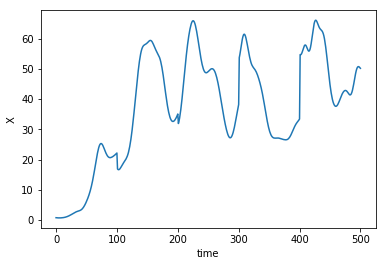

In [235]:
plot_rmse(enkf)

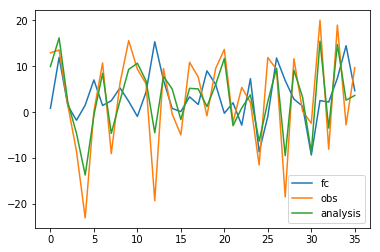

In [236]:
plt.plot(enkf.x_f, label='fc')
plt.plot(enkf.y, label='obs')
plt.plot(enkf.x_a, label='analysis')
plt.legend()

## Two level version

In [129]:
# Create initial conditions
l96 = L96TwoLevelUncoupled()
l96.iterate(10000)
init2 = l96.state

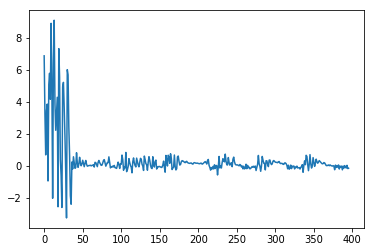

In [130]:
plt.plot(l96.state)

In [237]:
class EnKF():
    def __init__(self, l96, nens, obs_noise, nsteps):
        self.l96 = l96
        self.nens = nens
        self.obs_noise = obs_noise
        self.R = np.diag(np.ones(l96.state.shape) * obs_noise)   # No localization
        self.nsteps = nsteps
        
    def initialize(self, ic, ic_noise):
        # Initial conditions
        self.x_t = ic.copy()
        self.x_a = ic.copy() + np.random.normal(0, ic_noise, self.x_t.shape)
        self.x_a_ens = np.array([ic.copy()] * self.nens)
        self.x_a_ens += np.random.normal(0, ic_noise, self.x_a_ens.shape)
        
        # Models
        self.l96_tru = deepcopy(self.l96); self.l96_tru.set_state(self.x_t)
        self.l96_det = deepcopy(self.l96); self.l96_det.set_state(self.x_a)
        self.l96_ens = [deepcopy(self.l96) for n in range(self.nens)]
        for i, l in enumerate(self.l96_ens):
            l.set_state(self.x_a_ens[i])
        
    def step(self):
        # Forecast
        self.l96_det.iterate(self.nsteps)
        for l in self.l96_ens:
            l.iterate(self.nsteps)
        self.l96_tru.iterate(self.nsteps)
        
        # Get arrays
        self.x_f = self.l96_det.state
        self.x_f_ens = np.array([l.state for l in self.l96_ens])
        self.y = self.l96_tru.state + np.random.normal(0, self.obs_noise, self.l96_tru.state.shape)
        self.y_ens = np.array([self.y + np.random.normal(0, self.obs_noise, self.y.shape) for i in range(self.nens)])
        
        # New analysis
        K = self.kalman_gain(self.x_f_ens)
        self.x_a = self.x_f + K @ (self.y - self.x_f)
        self.x_a_ens = np.array([
            self.x_f_ens[i] + K @ (self.y_ens[i] - self.x_f_ens[i]) for i in range(self.nens)
        ])
        
        # Update state in models
        self.l96_det.set_state(self.x_a)
        for i, l in enumerate(self.l96_ens):
            l.set_state(self.x_a_ens[i])
    
    def kalman_gain(self, x_f_ens):
        X = (x_f_ens - x_f_ens.mean(0)).T
        Y = X
        K = X @ Y.T @ inv(Y @ Y.T + (self.nens -1) * self.R)
        return K
        
        
    def iterate(self, ncycles, noprog=False):
        for n in tqdm(range(ncycles), disable=noprog):
            self.step() 
        

In [184]:
noise = np.concatenate([np.ones(36), np.ones(36*10)*0.1]) / 10

In [255]:
enkf = EnKF(L96TwoLevelUncoupled(noprog=True), 50, 1e-3, 50)

In [256]:
enkf.R

array([[0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.001, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.001, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.001, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.001, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.001]])

In [257]:
enkf.initialize(init2, 1)

In [258]:
enkf.iterate(5)

In [261]:
def plot_rmse(enkf):
    rmse = (enkf.l96_tru.history - enkf.l96_det.history)**2
    rmse = rmse.mean('y')
    rmse.X_repeat.plot()
    rmse.Y.plot()

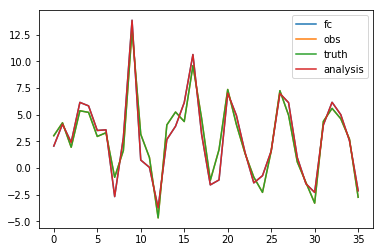

In [259]:
plt.plot(enkf.x_f[:36], label='fc')
plt.plot(enkf.y[:36], label='obs')
plt.plot(enkf.x_t[:36], label='truth')
plt.plot(enkf.x_a[:36], label='analysis')
plt.legend()

In [ ]:
enkf.

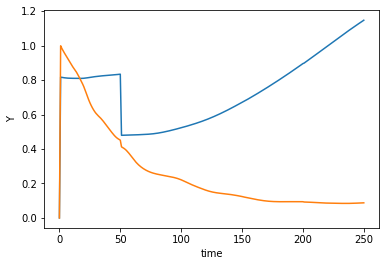

In [262]:
plot_rmse(enkf)